# 셋업 & 데이터 적재

In [72]:
# imports
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV


In [11]:
# load
df = pd.read_csv('../data/raw/connect-4.csv')
print("data size:", df.shape)
df.head()

data size: (67557, 43)


,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,...,f4,f5,f6,g1,g2,g3,g4,g5,g6,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


# 스키마 확인 & 기본 EDA

In [22]:
# schema / value check
print(df.dtypes)
print(df['target'].value_counts().sort_index())
# 모든 보드 칸이 {0,1,2}인지, target이 {0,1,2}인지 확인
board_cols = [c for c in df.columns if c != 'target']
for c in board_cols: 
    assert set(df[c].unique()).issubset({0,1,2}), f"Unexpected in {c}"
assert set(df['target'].unique()).issubset({0,1,2})

a1        int64
a2        int64
a3        int64
a4        int64
a5        int64
a6        int64
b1        int64
b2        int64
b3        int64
b4        int64
b5        int64
b6        int64
c1        int64
c2        int64
c3        int64
c4        int64
c5        int64
c6        int64
d1        int64
d2        int64
d3        int64
d4        int64
d5        int64
d6        int64
e1        int64
e2        int64
e3        int64
e4        int64
e5        int64
e6        int64
f1        int64
f2        int64
f3        int64
f4        int64
f5        int64
f6        int64
g1        int64
g2        int64
g3        int64
g4        int64
g5        int64
g6        int64
target    int64
dtype: object
target
0     6449
1    16635
2    44473
Name: count, dtype: int64


# 결측/중복/이상치 처리

In [27]:
# missing/duplicate
print(df.isna().sum().sum())
df = df.drop_duplicates()

0


# 베이스라인 세우기

In [41]:
# train/test split (stratify)
X, y = df[board_cols], df['target']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Dummy baseline (most_frequent)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_tr, y_tr)
y_pred = dummy.predict(X_te)
print('Dummy Acc:', accuracy_score(y_te, y_pred))
print('Dummy macro-F1:', f1_score(y_te, y_pred, average='macro'))

Dummy Acc: 0.6583185316755477
Dummy macro-F1: 0.2646530281933188


# 인코딩 전략 결정
### 1. 원-핫 인코딩 (보드 칸을 범주형으로 처리)
### 2. 숫자 0/1/2를 그대로 사용 (순서형 가정)

In [53]:
# two preprocessors
cat_cols = board_cols   # 전부 범주 취급
prep_onehot = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)], remainder='drop')

# 숫자 그대로: 전처리 없음(또는 StandardScaler로도 비교해볼 수 있음)
prep_numeric = 'passthrough'


# 모델 후보 구성
## LogisticRegression (multi_class='multinomial') – 빠른 baseline, 해석 용이
## DecisionTreeClassifier – 규칙 기반, 빠르고 직관적
## RandomForestClassifier – 강력한 앙상블(추천)
## SVM(RBF) – 성능 좋지만 느릴 수 있음(부분 샘플로 시도)

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [62]:
models = {
    "LogReg(onehot)": Pipeline([('prep', prep_onehot),
                                ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial'))]),

    "DecisionTree(onehot)": Pipeline([('prep', prep_onehot),
                                      ('clf', DecisionTreeClassifier(random_state=42))]),

    "RandomForest(onehot)": Pipeline([('prep', prep_onehot),
                                      ('clf', RandomForestClassifier(n_estimators=200, random_state=42))]),

    "LogReg(numeric)": Pipeline([('prep', prep_numeric),
                                 ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial'))]),
}

# 교차검증으로 1차 성능 비교 (Accuracy + Macro-F1)

In [69]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
macro_f1 = make_scorer(f1_score, average='macro')

cv_table = []
for name, pipe in models.items():
    acc = cross_val_score(pipe, X, y, scoring='accuracy', cv=skf).mean()
    f1m = cross_val_score(pipe, X, y, scoring=macro_f1, cv=skf).mean()
    cv_table.append((name, acc, f1m))
pd.DataFrame(cv_table, columns=["Model","CV Accuracy","CV Macro-F1"]).sort_values("CV Macro-F1", ascending=False)


,Model,CV Accuracy,CV Macro-F1
2,RandomForest(onehot),0.831091,0.630179
1,DecisionTree(onehot),0.762497,0.610243
0,LogReg(onehot),0.757242,0.500866
3,LogReg(numeric),0.660938,0.283627


# 하이퍼파라미터 탐색

In [74]:
# RandomForest 예: 깊이/리프/트리개수
rf_grid = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [None, 12, 20],
    'clf__min_samples_leaf': [1, 3, 5]
}
rf_pipe = Pipeline([('prep', prep_onehot), ('clf', RandomForestClassifier(random_state=42))])
rf_gs = GridSearchCV(rf_pipe, rf_grid, scoring=macro_f1, cv=skf, n_jobs=-1)
rf_gs.fit(X_tr, y_tr)
print("RF best:", rf_gs.best_params_, rf_gs.best_score_)

# LogisticRegression 예: C 규제 강도
log_grid = {'clf__C': [0.5, 1.0, 2.0]}
log_pipe = Pipeline([('prep', prep_onehot), ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial'))])
log_gs = GridSearchCV(log_pipe, log_grid, scoring=macro_f1, cv=skf, n_jobs=-1)
log_gs.fit(X_tr, y_tr)
print("LogReg best:", log_gs.best_params_, log_gs.best_score_)


RF best: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200} 0.6159210171171282
LogReg best: {'clf__C': 2.0} 0.5032400769658105


# 테스트 성능 보고 + 혼동행렬/리포트

Test Accuracy: 0.8328004736530491
Test Macro-F1: 0.6325574911543822
              precision    recall  f1-score   support

           0     0.5861    0.1309    0.2140      1612
           1     0.8277    0.7439    0.7836      4159
           2     0.8412    0.9678    0.9001     11119

    accuracy                         0.8328     16890
   macro avg     0.7517    0.6142    0.6326     16890
weighted avg     0.8136    0.8328    0.8059     16890



NameError: name 'plt' is not defined

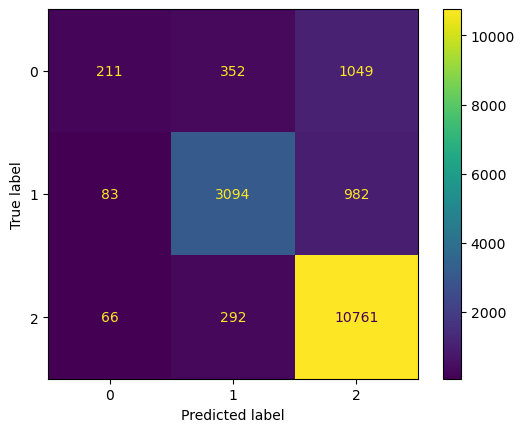

In [77]:
# 가장 좋은 모델 선택 (여기서는 rf_gs, log_gs 중 높은 CV score)
best = rf_gs if rf_gs.best_score_ >= log_gs.best_score_ else log_gs
y_pred = best.predict(X_te)

print("Test Accuracy:", accuracy_score(y_te, y_pred))
print("Test Macro-F1:", f1_score(y_te, y_pred, average='macro'))
print(classification_report(y_te, y_pred, digits=4))

ConfusionMatrixDisplay.from_predictions(y_te, y_pred)
plt.title("Confusion Matrix (Connect-4)")
plt.show()
